# COVID-19 Dashboard - Canada

### This is a dashboard for visualizing Canadian COVID statistics using the OpenCOVID API.

By default, daily new infections and daily deaths will be visualized if data regarding only a specific health region is queried. For data queried at a provincial, territorial, or national level, visualizations concerning hospitalizations and ICU occupancies will also be included. 

While this is currently the only data visualized, the OpenCOVID API also includes support for additional data at the provincial, territorial, or national level, regarding COVID testing, vaccine administration, and vaccine coverage, with data being separable for each vaccine dose up to and including the fourth. Additional support for the extended data as well as additional data representations such as tables are being considered for this dashboard for future updates. 

***

Requested data can be customized via editing the following four parameters, as follows: 



In [1]:
# PARAMS: change these to see different data

geographic_data_level = 'pt'
# This can be 'pt' for provincial or territorial, 'hr' for health region, or 'can' for the entirety of Canada. 

start_date = '2023-01-01'
# This is the first day that you want to see data for. Nothing before this date will be shown.

end_date = '2023-02-15'
# This is the final day that you want to see data for. Nothing after this date will be shown.

The final parameter is our location ID. This is either a two letter province or territory abbreviation, or a three or four digit health region code. Please note that hospitalization data is only provided for data at or above the provincial level. In the event that data is only requested for a specific health region, only case and death data are available. This is a limit of the OpenCOVID API, which this notebook uses.   

[The lookup table for individual health regions and provincial abbreviations can be found here:](https://github.com/ccodwg/CovidTimelineCanada/blob/main/geo/hr.csv)

https://github.com/ccodwg/CovidTimelineCanada/blob/main/geo/hr.csv

For health region codes, refer to values under the column `hruid`, and for provincial abbreviations, please reference the values under the column labelled `region`.

In [2]:
# PARAM: change this to see different data

location_ID = 'ON'
# This is either a two letter province or territory abbreviation, or a three or four digit health region code.
# Examples would be 'BC' for British Columbia, 'AB' for Alberta, '593' for Vancouver Coastal Health, or '4601' for Winnipeg Regional Health Authority. 
# If you want to see data for the entirety of Canada, change this to an empty string - ''.

The following code runs using our provided parameters from above. 

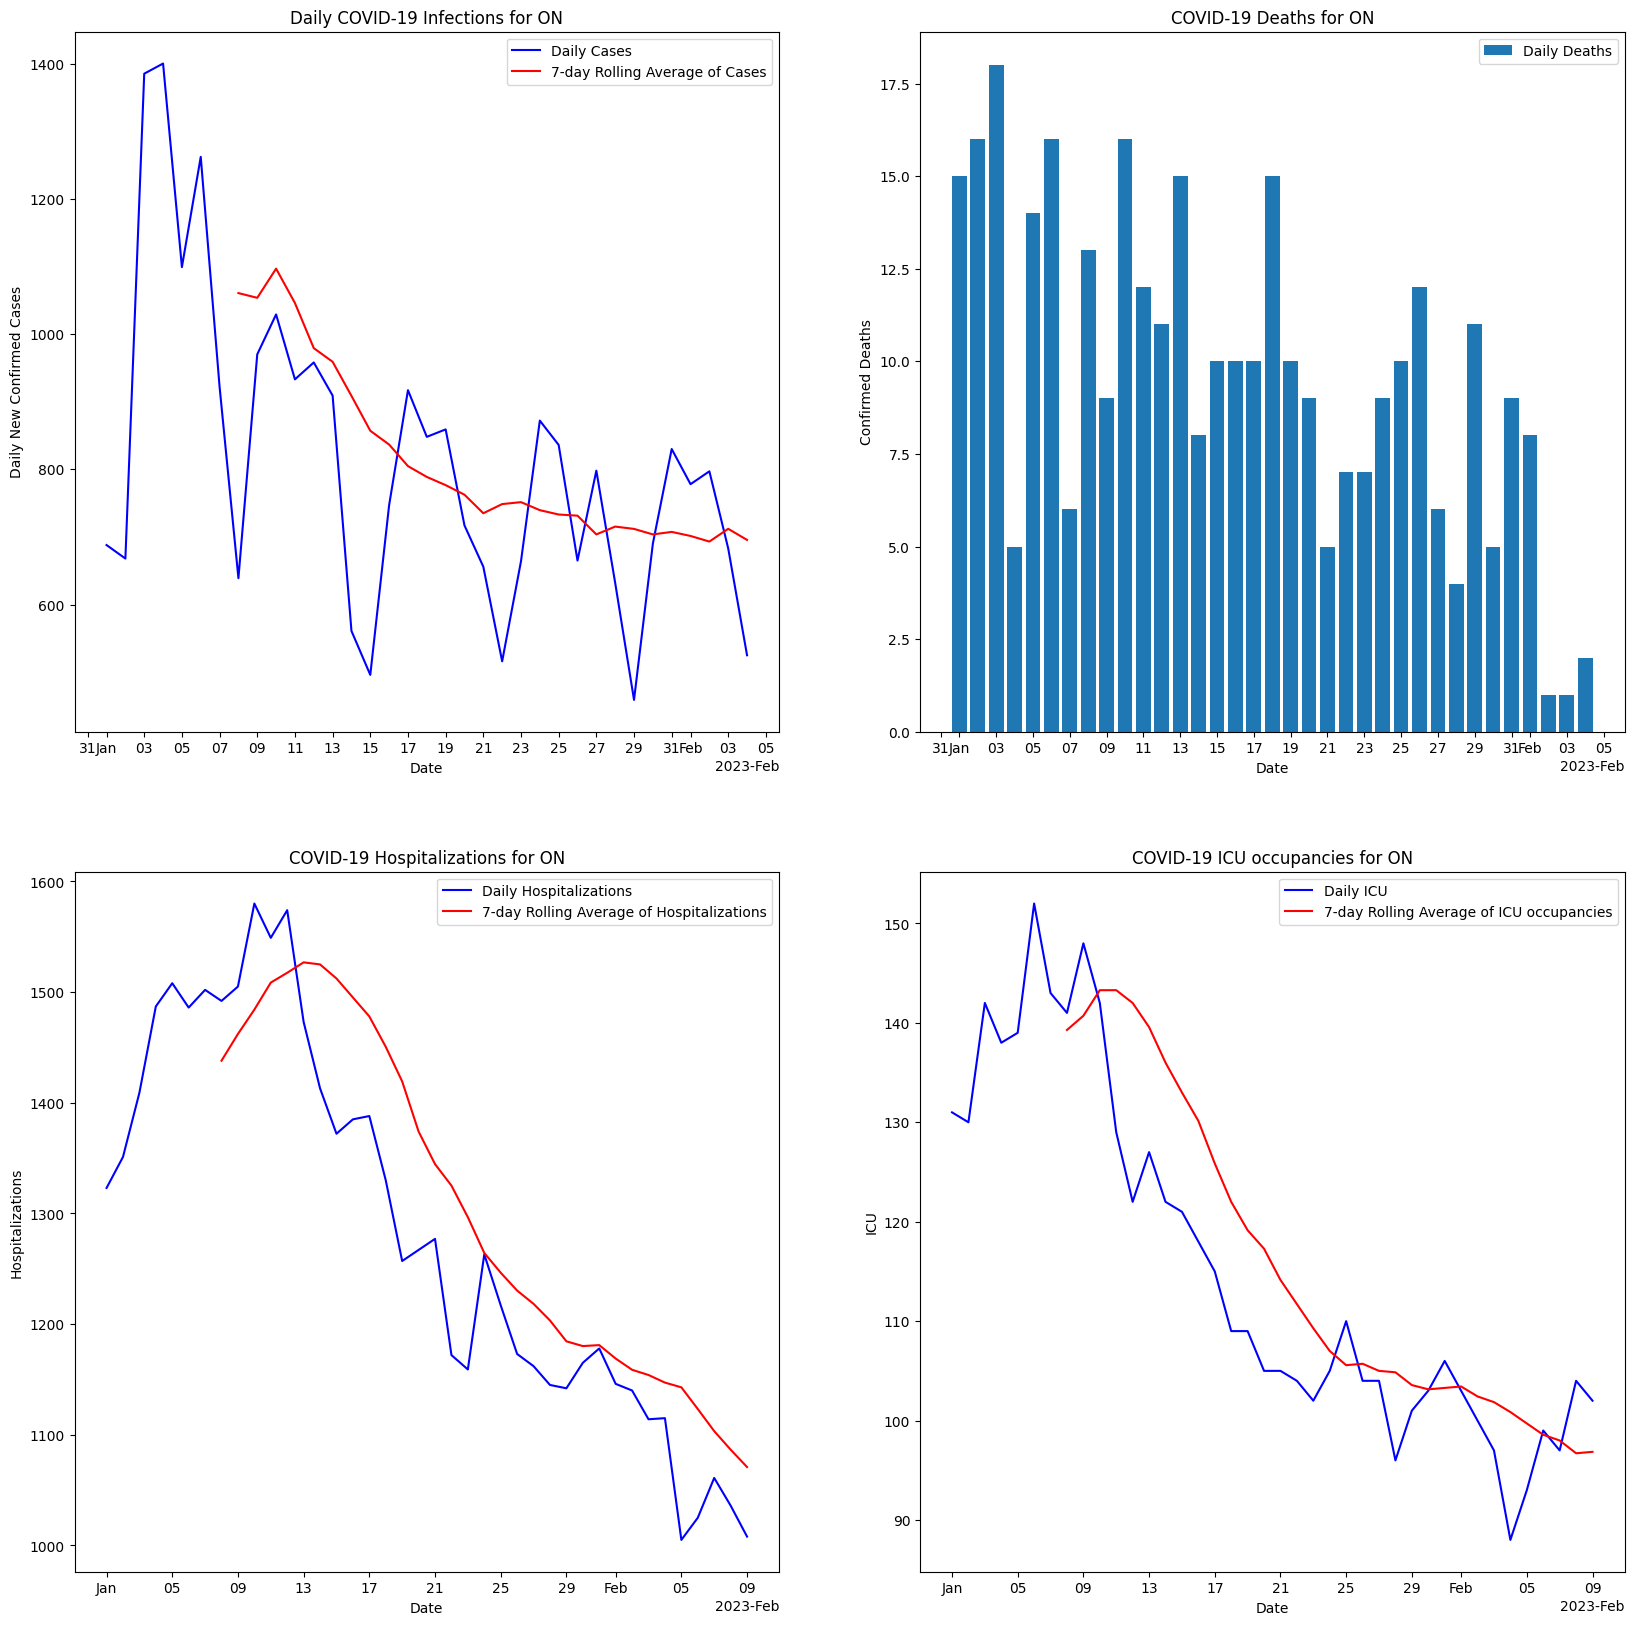

In [3]:
import datetime, json, requests
import matplotlib.pyplot as plt
import  matplotlib.dates as mdates
%matplotlib inline

def rolling_avg(data, window_size):
    '''returns a list of rolling averages for a given list of data, using a given window size'''
    return [sum(data[i-window_size:i])/window_size for i in range(window_size, len(data))]

def format_date_axis(ax):
    '''format the dates shown on the x-axis of given axes, ax'''
    locator = mdates.AutoDateLocator(minticks=10, maxticks=20)
    formatter = mdates.ConciseDateFormatter(locator)
    ax.xaxis.set_major_locator(locator)
    ax.xaxis.set_major_formatter(formatter)

def subquery_data(query_type, result_data, value_type):
    '''used to gather information for the subqueries for pt and above, such as hospitalizations, ICU counts, and tests.'''
    query_data = result_data[query_type] # get the data for the subquery
    query_dates = [daily['date'] for daily in query_data] # extract the date strings
    n_query = [daily[value_type] for daily in query_data] # extract the data values - whether we want daily or cumulative values
    query_datetime_objects = [datetime.datetime.strptime(date, '%Y-%m-%d') for date in query_dates]
    query_dates = [dt.date() for dt in query_datetime_objects]
    # query 7-day rolling averages
    if query_type != 'deaths':
        query_rolling = rolling_avg(n_query, 7)
        query_dates_rolling = query_dates[7:]
        return query_dates, n_query, query_dates_rolling, query_rolling
    else:
        return query_dates, n_query

# response data
query = 'https://api.opencovid.ca/timeseries?geo=' + geographic_data_level + '&loc=' + location_ID + '&after=' + start_date + '&before=' + end_date
# first api call uses the default value for stat, returning the total number of cases and deaths
# this doesn't include data for hospitalizations, tests, ICU counts, etc.
# so we'll have to make a separate API call for that information. However, we can use the same parameters for inputs,
# as we're going to hardcore the stat parameter for the later API calls. 
response = requests.request("GET", query, headers={}, data={})
result = json.loads(response.text)
result_data = result['data']

# case data
case_dates, n_cases, cases_dates_rolling, cases_rolling = subquery_data('cases', result_data, 'value_daily')
# plot cases as a line chart using matplotlib
# if we're looking at the provincial level or higher, we can include graphs for hospitalizations and ICU counts as well.
# otherwise, if we're only looking at a specific health region, we only need two graphs - one for cases and one for deaths.
if geographic_data_level != 'hr':
    fig, [[ax1, ax2], [ax3, ax4]] = plt.subplots(nrows=2, ncols=2, figsize = [20,20])
else:
    fig, [ax1, ax2] = plt.subplots(nrows=2, figsize = [20,20])
format_date_axis(ax1)
ax1.plot(case_dates, n_cases, c ='b', label='Daily Cases')  # Plot some data on the axes.
ax1.plot(cases_dates_rolling, cases_rolling, c='r', label='7-day Rolling Average of Cases')
ax1.set_xlabel('Date')  # Add an x-label to the axes.
ax1.set_ylabel('Daily New Confirmed Cases')  # Add a y-label to the axes.
ax1.set_title(f'Daily COVID-19 Infections for {location_ID}')  # Add a title to the axes.
ax1.legend()

# death data
death_dates, n_deaths = subquery_data('deaths', result_data, 'value_daily')
'''plot deaths as a bar chart using matplotlib'''
ax2.bar(death_dates, n_deaths, label='Daily Deaths')  # Plot some data on the axes.
format_date_axis(ax2)
ax2.set_xlabel('Date')  # Add an x-label to the axes.
ax2.set_ylabel('Confirmed Deaths')  # Add a y-label to the axes.
ax2.set_title(f'COVID-19 Deaths for {location_ID}') 
ax2.legend()

# if we're looking at the provincial level or higher, we can include graphs for additional data as well.
if geographic_data_level != 'hr':
    # hospitalization data
    hosp_dates, n_hosp, hosp_dates_rolling, hosp_rolling = subquery_data('hospitalizations', result_data, 'value')
    # plot hospitalizations as a line graph using matplotlib
    ax3.plot(hosp_dates, n_hosp, c ='b', label='Daily Hospitalizations')  # Plot some data on the axes.
    ax3.plot(hosp_dates_rolling, hosp_rolling, c='r', label='7-day Rolling Average of Hospitalizations')
    format_date_axis(ax3)
    ax3.set_xlabel('Date')  # Add an x-label to the axes.
    ax3.set_ylabel('Hospitalizations')  # Add a y-label to the axes.
    ax3.set_title(f'COVID-19 Hospitalizations for {location_ID}')  # Add a title to the axes.
    ax3.legend()

    # ICU data
    icu_dates, n_icu, icu_dates_rolling, icu_rolling = subquery_data('icu', result_data, 'value')
    # plot ICU as a line graph using matplotlib
    ax4.plot(icu_dates, n_icu, c ='b', label='Daily ICU')  # Plot some data on the axes.
    ax4.plot(icu_dates_rolling, icu_rolling, c='r', label='7-day Rolling Average of ICU occupancies')
    format_date_axis(ax4)
    ax4.set_xlabel('Date')  # Add an x-label to the axes.
    ax4.set_ylabel('ICU')  # Add a y-label to the axes.
    ax4.set_title(f'COVID-19 ICU occupancies for {location_ID}')  # Add a title to the axes.
    ax4.legend()